In [20]:
import numpy as np
import scipy.signal as signal
%matplotlib inline
import matplotlib.pyplot as plt
import SchemDraw
import SchemDraw.elements as e

# Aphex Aural Exciter (Type B) Tone Circuit

Here we explore the tone circuit for the Aphex Type B Aural Exciter. This a great circuit for learning about circuit modelling for audio DSP, because it is a relatively simple circuit, but it has an interesting response, requires us to think about a few important aspects of virtual analog modelling, and most importantly it sounds great!

## The circuit

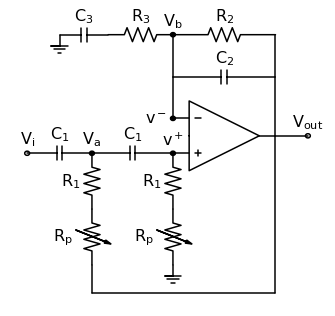

In [21]:
d = SchemDraw.Drawing()
o = d.add(e.OPAMP)
outLine = d.add(e.LINE, xy=o.out, l=.5)
d.add(e.LINE, l=1)
d.add(e.DOT_OPEN, label='$V_{out}$')
d.add(e.LINE, xy=o.in1, d='left', l=.5)
d.add(e.DOT, d='down', label='$v^-$')
d.add(e.LINE, d='up', l=1.5)
C2 = d.add(e.CAP, d='right', tox=outLine.end, l=1, label='$C_2$')
d.add(e.LINE, d='down', toy=outLine.start)
d.add(e.LINE, d='up', xy=C2.start, l=1.5)
R2 = d.add(e.RES, d='right', tox=C2.end, label='$R_2$')
d.add(e.LINE, d='down', toy=C2.end)
d.add(e.DOT, xy=R2.start, label='$V_b$')
R3 = d.add(e.RES, d='left', xy=R2.start, l=2, label='$R_3$')
C3 = d.add(e.CAP, d='left', l=1.5, label='$C_3$')
d.add(e.GND)
d.add(e.LINE, xy=o.in2, d='left', l=.5)
d.add(e.DOT, label='$v^+$')
R1_2 = d.add(e.RES, d='down', l=2, label='$R_1$')
Rp_2 = d.add(e.RES_VAR, l=2, d='down', label='$R_p$')
d.add(e.GND)
C1_2 = d.add(e.CAP, d='left', l=2.5, xy=R1_2.start, label='$C_1$')
d.add(e.DOT, label='$V_a$')
C1_1 = d.add(e.CAP, d='left', l=2, xy=C1_2.end, label='$C_1$')
d.add(e.DOT_OPEN, label='$V_i$')
R1_1 = d.add(e.RES, d='down', l=2, xy=C1_1.start, label='$R_1$')
Rp_1 = d.add(e.RES_VAR, d='down', l=2, label='$R_p$')
d.add(e.LINE, d='down', l=1)
d.add(e.LINE, d='right', tox=outLine.end)
d.add(e.LINE, d='up', toy=outLine.end)
d.draw()

### Solving the circuit

EDIT: The below analysis is actually incorrect. However, I'm leaving this here because the transfer function that results end up being pretty neat. The actual transfer function of this filter is that of a "Sallen-Key Highpass Filter"
To solve this circuit, we need can use our ideal op-amp equation, which asserts that $v^+ = v^-$, and that the current going into the op-amp is identically 0.

We can also use complex impedances to solve the circuit in the Laplace domain, which as we will soon see, will help us examine the circuit's frequency response. To do that we must recognize that the impedance of a resistance $R$ is $Z_r = R$, and the impedance ofa capacitance $C$ is $Z_c = \frac{1}{Cs}$.

Let us start by examining the current $I_3$ going through $R_3$. By Ohm's law, and after simplification, we can say that $I_3 = V_b \frac{C_3 s}{R_3C_3s + 1}$. Since no current goes into the op-amp, we know the same current travels through the parallel combination of $C_2$ and $R_2$. Again after Ohm's law, we can write that $I_3 = (V_o - V_b) \frac{R_2C_2s + 1}{R_2}$. By combining these equations we find,
$$ V_o = V_b \bigg(1 + \frac{R_2 C_3 s}{R_2 R_3 C_2 C_3 s^2 + (R_2 C_2 + R_3 C_3)s + 1} \bigg) $$

Now to connect this solution to our bottom half of the circuit, we can use our op-amp equation to recognize that $V_b = v^+$.

On the bottom half of the circuit, consider current $I_0$ going from $V_i$ to $V_a$, current $I_1$ going from $V_o$ to $V_a$, and current $I_2$ going from $v^+$ to ground. Using Ohm's law we get:
$$ I_0 = (V_i - V_a)C_1s, \quad I_1 = (V_o - V_a) \frac{1}{R_1 + R_p}, \quad I_2 = \frac{v^+}{R_1 + R_p} = V_a \frac{C_1s}{(R_1 + R_p)C_1s + 1} $$

Using the two equalities for $I_2$, we can find $V_a = v^+ \frac{(R_1 + R_p)C_1s + 1}{(R_1 + R_p)C_1s}$. Then using our equation for $V_b$ from above, we can write $V_a$ in terms of $V_o$.

Now using Kirchoff's Current Law, we know, $I_0 + I_1 = I_2$, which we can now write entirely in terms of $V_i$ and $V_o$. Finally, solving for $V_o$ in terms of $V_i$, we find:

$$ \boxed{ H(s) = \frac{V_o}{V_i} = \frac{R_2 C_3}{(R_1 + R_p)^2 C_1^2 R_2 C_3 s^2 + 4(R_1+R_p)C_1 R_2(R_3C_2 + 2C_3)s + 4(R_1+R_p)C_1R_3} } $$

We can now use this Laplace domain solution to examine a virtual analog implementation of this circuit.

## Analog analysis

First let's plug in the correct component values for this circuit (note that the potentiometers are log scale from 0-50 kOhms), and get a sense of what this circuit is supposed to look like.

In [22]:
# Component values
C_1 = 4.7e-9
C_2 = 56e-12
C_3 = 4.7e-6
R_1 = 10000
R_2 = 2400
R_3 = 1000
R_ps = [5, 2500, 5000, 10000, 15000, 25000, 35000, 50000] # 0 - 50k

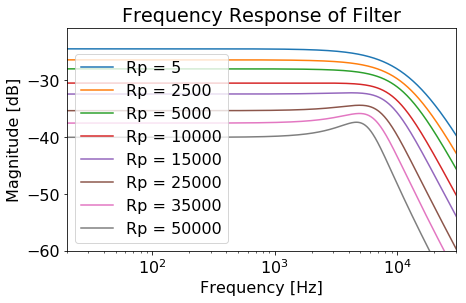

In [23]:
# plot freq response
plt.figure()
names = []
for R_p in R_ps:
    R_1p = R_1 + R_p
    
    a2 = R_1p**2 * C_1**2 * R_2 * C_3
    a1 = 4 * R_1p * C_1 * R_2 * (R_3 * C_2 + 2 * C_3)
    a0 = 4 * R_1p * C_1 * R_3
    
    b2 = 0
    b1 = 0
    b0 = R_2 * C_3
    
    w, H = signal.freqs ([b2, b1, b0], [a2, a1, a0], worN=np.logspace (1, 6, 1000))
    plt.semilogx (w / (2 * np.pi), 20 * np.log10 (np.abs (H)))
    names.append ('Rp = {}'.format (R_p))

plt.xlim ((20, 30000))
plt.ylim (-60)
plt.title ('Frequency Response of Filter')
plt.xlabel ('Frequency [Hz]')
plt.ylabel ('Magnitude [dB]')
plt.legend (names)

So this is a pretty nifty circuit. At first it looks like a standard Lowpass Filter, but as cutoff frequency goes down, the resonance increases.

## Digitization

There are a number of ways to digitize a circuit such as this, but one common one, uses the bilinear transform.
$$ s \rightarrow c\frac{1 - z^{-1}}{1 + z^{-1}} $$

The standard bilinear transform chooses $c = \frac{2}{T}$, where $T$ is the sampling period of the digital system. However it is well known that this choice of $c$ introduces frequency warping at high frequencies. Another option is to use the parametric bilinear transform. Here we choose $c = \omega_c \cot(\omega_c T/2)$, where $w_c$ is an analog frequency that we want to match with our digital filter.

For this circuit, I chose to use the parametric bilinear transform to match the pole frequency of the circuit. One thing to watch out for in this case, is that the pole frequency changes depending on the value of the potentiometers $R_p$. Below, we show how to find the pole frequency for $R_p = 50 k\Omega$.

Pole frequency: 5166.731 Hz


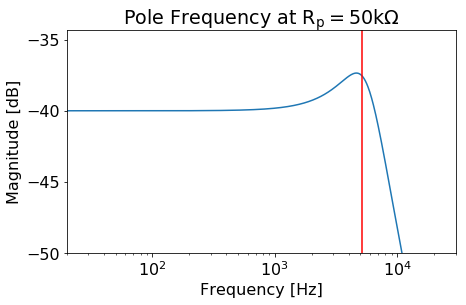

In [24]:
# Example of finding pole frequency
plt.figure()
R_p = 50000
R_1p = R_1 + R_p

a2 = R_1p**2 * C_1**2 * R_2 * C_3
a1 = 4 * R_1p * C_1 * R_2 * (R_3 * C_2 + 2 * C_3)
a0 = 4 * R_1p * C_1 * R_3

b2 = 0
b1 = 0
b0 = R_2 * C_3

w, H = signal.freqs ([b2, b1, b0], [a2, a1, a0], worN=np.logspace (1, 6, 1000))
plt.semilogx (w / (2 * np.pi), 20 * np.log10 (np.abs (H)))

plt.xlim ((20, 30000))
plt.ylim (-50)
plt.title (r'Pole Frequency at $R_p = 50 k\Omega$')
plt.xlabel ('Frequency [Hz]')
plt.ylabel ('Magnitude [dB]')

det = a1**2 - 4*a0*a2
pole = np.sqrt (np.abs (det)) / (2 * a2)
freq = pole / (2 * np.pi)
print ('Pole frequency: {0:.3f} Hz'.format (freq))
plt.axvline (freq, color='r')

Now how important is this parameterization? Let's compare

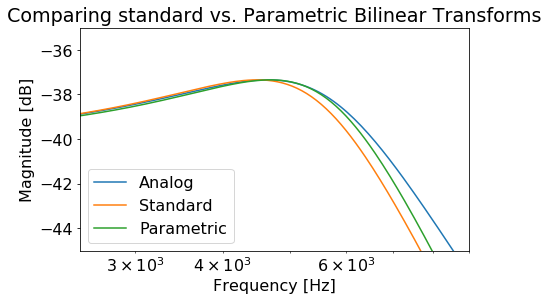

In [82]:
# Example of finding pole frequency
plt.figure()
R_p = 50000
R_1p = R_1 + R_p

# analog response
a2 = R_1p**2 * C_1**2 * R_2 * C_3
a1 = 4 * R_1p * C_1 * R_2 * (R_3 * C_2 + 2 * C_3)
a0 = 4 * R_1p * C_1 * R_3

b2 = 0
b1 = 0
b0 = R_2 * C_3

w, H = signal.freqs ([b2, b1, b0], [a2, a1, a0], worN=np.logspace (1, 6, 1000))
plt.semilogx (w / (2 * np.pi), 20 * np.log10 (np.abs (H)))

# Standard bilinear
T = 1.0 / 44100
c = 2.0 / T
a0B = a2 * c**2 + a1 * c + a0
a1B = 2.0 * (a0 - a2 * c**2) / a0B
a2B = (a2 * c**2 - a1 * c + a0) / a0B
b0B = (b2 * c**2 + b1 * c + b0) / a0B
b1B = 2.0 * (b0 - b2 * c**2) / a0B
b2B = (b2 * c**2 - b1 * c + b0) / a0B

w, HB = signal.freqz ([b0B, b1B, b2B], [1, a1B, a2B], worN=np.logspace (1, 4.5, 1000), fs=1/T)
plt.semilogx (w, 20 * np.log10 (np.abs (HB)))

# Parametric bilinear
wc = np.sqrt (np.abs (a1*a1 - 4.0*a0*a2)) / (2.0 * a2);
c =  wc / np.tan (wc * T / 2.0);
a0P = a2 * c**2 + a1 * c + a0
a1P = 2.0 * (a0 - a2 * c**2) / a0P
a2P = (a2 * c**2 - a1 * c + a0) / a0P
b0P = (b2 * c**2 + b1 * c + b0) / a0P
b1P = 2.0 * (b0 - b2 * c**2) / a0P
b2P = (b2 * c**2 - b1 * c + b0) / a0P

w, HP = signal.freqz ([b0P, b1P, b2P], [1, a1P, a2P], worN=np.logspace (1, 4.5, 1000), fs=1/T)
plt.semilogx (w, 20 * np.log10 (np.abs (HP)))

plt.xlim ((2500, 9000))
plt.ylim ((-45, -35))
plt.title ('Comparing standard vs. Parametric Bilinear Transforms')
plt.xlabel ('Frequency [Hz]')
plt.ylabel ('Magnitude [dB]')
plt.legend (['Analog', 'Standard', 'Parametric'])

So in this case it's not a huge difference, but there *is* a difference. This is just to show that if the circuit you're working with has important frequencies (especially high frequencies), it may be worth your while to match them with a bilinear transform.